# Libraries

In [3]:
# Reading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import optuna
from optuna import Trial
from scipy.stats import norm
import scipy.stats as stats
import joblib
import json
import pickle

# Ignore warnings and view all columns
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)

In [4]:
# Reading the dataset
df = pd.read_csv('../data/fps-dataset-feature.csv')
print(df.shape)
df.head()

(93695, 49)


,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,GpuCpuRatio,CacheCoreRatio,CpuOverclockPotential,EffectiveMemory,PerformanceClockRatio,PerformancePerWatt,CpuCoreThreadRatio,CpuPowerIndex,GpuAverageClock,FPS
0,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon 550,GCN 4.0,56000.0,1100.0,1183.0,PCIe 3.0 x8,0.000103,12,1211000.0,64.0,2000.0,GDDR5,2.0,4.6,18930.0,14.0,16.0,6.4,512.0,32.0,37860.0,2200.0,1.2.131,fortnite,1080.0,med,0.369688,610.0,31.0,3584000.0,2.704987,550.454545,0.5,25600.0,1141.5,120.0
1,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon 550,GCN 4.0,56000.0,1100.0,1183.0,PCIe 3.0 x8,0.000103,12,1211000.0,64.0,2000.0,GDDR5,2.0,4.6,18930.0,14.0,16.0,6.4,512.0,32.0,37860.0,2200.0,1.2.131,minecraft,720.0,high,0.369688,610.0,31.0,3584000.0,2.704987,550.454545,0.5,25600.0,1141.5,120.0
2,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7750,GCN 1.0,72000.0,800.0,800.0,PCIe 3.0 x16,0.000123,12,819200.0,128.0,1024.0,GDDR5,1.2,4.6,12800.0,28.0,16.0,5.1,512.0,32.0,25600.0,1500.0,1.2.131,grandTheftAuto5,720.0,med,0.250000,610.0,31.0,9216000.0,4.000000,546.133333,0.5,25600.0,800.0,50.0
3,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7850,GCN 1.0,153600.0,860.0,860.0,PCIe 3.0 x16,0.000212,12,1761000.0,256.0,2000.0,GDDR5,1.2,4.6,27520.0,28.0,32.0,5.1,1024.0,64.0,55040.0,2800.0,1.2.131,apexLegends,720.0,low,0.268750,610.0,31.0,39321600.0,3.720930,628.928571,0.5,25600.0,860.0,30.0
4,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7850,GCN 1.0,153600.0,860.0,860.0,PCIe 3.0 x16,0.000212,12,1761000.0,256.0,2000.0,GDDR5,1.2,4.6,27520.0,28.0,32.0,5.1,1024.0,64.0,55040.0,2800.0,1.2.131,apexLegends,720.0,med,0.268750,610.0,31.0,39321600.0,3.720930,628.928571,0.5,25600.0,860.0,30.0


In [5]:
# Delete columns that are not important
delete_colums = ['CpuName', 'GpuName', 'GpuOpenGL', 'GpuShaderModel', 'GpuVulkan']
df = df.drop(delete_colums, axis=1)
print(df.shape)
df.head()

(93695, 44)


,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GameName,GameResolution,GameSetting,GpuCpuRatio,CacheCoreRatio,CpuOverclockPotential,EffectiveMemory,PerformanceClockRatio,PerformancePerWatt,CpuCoreThreadRatio,CpuPowerIndex,GpuAverageClock,FPS
0,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,GCN 4.0,56000.0,1100.0,1183.0,PCIe 3.0 x8,0.000103,12,1211000.0,64.0,2000.0,GDDR5,2.0,18930.0,14.0,16.0,512.0,32.0,37860.0,2200.0,fortnite,1080.0,med,0.369688,610.0,31.0,3584000.0,2.704987,550.454545,0.5,25600.0,1141.5,120.0
1,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,GCN 4.0,56000.0,1100.0,1183.0,PCIe 3.0 x8,0.000103,12,1211000.0,64.0,2000.0,GDDR5,2.0,18930.0,14.0,16.0,512.0,32.0,37860.0,2200.0,minecraft,720.0,high,0.369688,610.0,31.0,3584000.0,2.704987,550.454545,0.5,25600.0,1141.5,120.0
2,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,GCN 1.0,72000.0,800.0,800.0,PCIe 3.0 x16,0.000123,12,819200.0,128.0,1024.0,GDDR5,1.2,12800.0,28.0,16.0,512.0,32.0,25600.0,1500.0,grandTheftAuto5,720.0,med,0.250000,610.0,31.0,9216000.0,4.000000,546.133333,0.5,25600.0,800.0,50.0
3,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,GCN 1.0,153600.0,860.0,860.0,PCIe 3.0 x16,0.000212,12,1761000.0,256.0,2000.0,GDDR5,1.2,27520.0,28.0,32.0,1024.0,64.0,55040.0,2800.0,apexLegends,720.0,low,0.268750,610.0,31.0,39321600.0,3.720930,628.928571,0.5,25600.0,860.0,30.0
4,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,GCN 1.0,153600.0,860.0,860.0,PCIe 3.0 x16,0.000212,12,1761000.0,256.0,2000.0,GDDR5,1.2,27520.0,28.0,32.0,1024.0,64.0,55040.0,2800.0,apexLegends,720.0,med,0.268750,610.0,31.0,39321600.0,3.720930,628.928571,0.5,25600.0,860.0,30.0


### Save Json

In [6]:
# Read the dataset with the features cleaned
df_clean = pd.read_csv('../data/fps-dataset-feature_clean.csv')
print(df_clean.shape)
df_clean.head()

(93695, 49)


,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,GpuCpuRatio,CacheCoreRatio,CpuOverclockPotential,EffectiveMemory,PerformanceClockRatio,PerformancePerWatt,CpuCoreThreadRatio,CpuPowerIndex,GpuAverageClock,FPS
0,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon 550,GCN 4.0,56000.0,1100.0,1183.0,PCIe 3.0 x8,0.000103,12,1211000.0,64.0,2000.0,GDDR5,2.0,4.6,18930.0,14.0,16.0,6.4,512.0,32.0,37860.0,2200.0,1.2.131,fortnite,1080.0,med,0.369688,610.0,31.0,3584000.0,2.704987,550.454545,0.5,25600.0,1141.5,120.0
1,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon 550,GCN 4.0,56000.0,1100.0,1183.0,PCIe 3.0 x8,0.000103,12,1211000.0,64.0,2000.0,GDDR5,2.0,4.6,18930.0,14.0,16.0,6.4,512.0,32.0,37860.0,2200.0,1.2.131,minecraft,720.0,high,0.369688,610.0,31.0,3584000.0,2.704987,550.454545,0.5,25600.0,1141.5,120.0
2,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7750,GCN 1.0,72000.0,800.0,800.0,PCIe 3.0 x16,0.000123,12,819200.0,128.0,1024.0,GDDR5,1.2,4.6,12800.0,28.0,16.0,5.1,512.0,32.0,25600.0,1500.0,1.2.131,grandTheftAuto5,720.0,med,0.250000,610.0,31.0,9216000.0,4.000000,546.133333,0.5,25600.0,800.0,50.0
3,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7850,GCN 1.0,153600.0,860.0,860.0,PCIe 3.0 x16,0.000212,12,1761000.0,256.0,2000.0,GDDR5,1.2,4.6,27520.0,28.0,32.0,5.1,1024.0,64.0,55040.0,2800.0,1.2.131,apexLegends,720.0,low,0.268750,610.0,31.0,39321600.0,3.720930,628.928571,0.5,25600.0,860.0,30.0
4,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7850,GCN 1.0,153600.0,860.0,860.0,PCIe 3.0 x16,0.000212,12,1761000.0,256.0,2000.0,GDDR5,1.2,4.6,27520.0,28.0,32.0,5.1,1024.0,64.0,55040.0,2800.0,1.2.131,apexLegends,720.0,med,0.268750,610.0,31.0,39321600.0,3.720930,628.928571,0.5,25600.0,860.0,30.0


In [7]:
# Create a dictionary to encode the categorical variables
def create_json_variables():
    cpu_dict = df_clean.groupby('CpuName').agg({
        'CpuNumberOfCores': 'mean', 
        'CpuNumberOfThreads': 'mean', 
        'CpuBaseClock': 'mean', 
        'CpuCacheL1': 'mean', 
        'CpuCacheL2': 'mean', 
        'CpuCacheL3': 'mean', 
        'CpuFrequency': 'mean', 
        'CpuMultiplier': 'mean', 
        'CpuMultiplierUnlocked': 'mean', 
        'CpuProcessSize': 'mean', 
        'CpuTDP': 'mean', 
        'CpuTurboClock': 'mean'
    }).to_dict(orient='index')
    
    gpu_dict = df_clean.groupby('GpuName').agg({
        'GpuArchitecture': 'first', #categorical
        'GpuBandwidth': 'mean', 
        'GpuBaseClock': 'mean', 
        'GpuBoostClock': 'mean', 
        'GpuBus nterface': 'first', #categorical
        'GpuDieSize': 'mean', 
        'GpuDirectX': 'first', #categorical
        'GpuFP32Performance': 'mean', 
        'GpuMemoryBus': 'mean', 
        'GpuMemorySize': 'mean', 
        'GpuMemoryType': 'first', #categorical
        'GpuOpenCL': 'mean',  
        'GpuPixelRate': 'mean', 
        'GpuProcessSize': 'mean', 
        'GpuNumberOfROPs': 'mean', 
        'GpuNumberOfShadingUnits': 'mean', 
        'GpuNumberOfTMUs': 'mean', 
        'GpuTextureRate': 'mean', 
        'GpuNumberOfTransistors': 'mean', 
    }).to_dict(orient='index')
    
    game_name_list = df_clean['GameName'].unique().tolist()
    game_setting_list = df_clean['GameSetting'].unique().tolist()
    game_resolution = df_clean['GameResolution'].unique().tolist()
    
    combined_dict = {
        'CpuName': cpu_dict,
        'GpuName': gpu_dict,
        'GameName': game_name_list,
        'GameSetting': game_setting_list,
        'GameResolution': game_resolution
    }
    return combined_dict

combined_dict = create_json_variables()
json_output = json.dumps(combined_dict, indent=4)

with open('../data/json/variables_dict.json', 'w') as json_file:
    json_file.write(json_output)

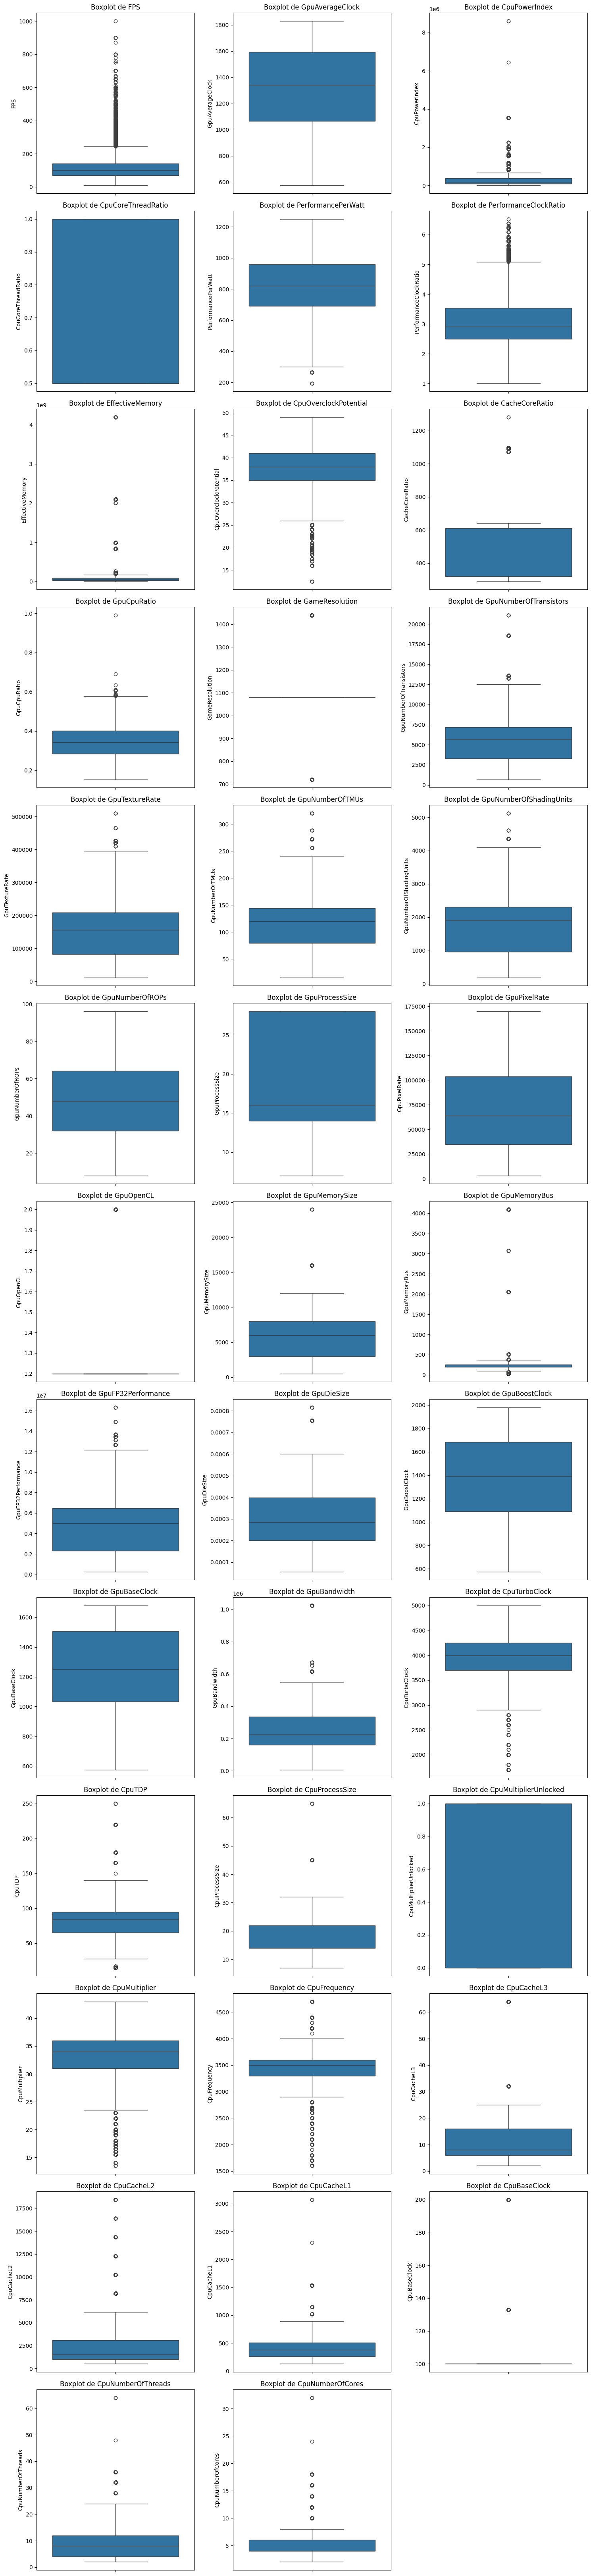

In [8]:
# Visualize the distribution of each numerical variable
def create_boxplots(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    num_cols = len(columns)
    num_rows = (num_cols + 2) // 3
    plt.figure(figsize=(15, 5 * num_rows))
    for i, col in enumerate(reversed(columns)):
        plt.subplot(num_rows, 3, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot de {col}')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()
    
create_boxplots(df)

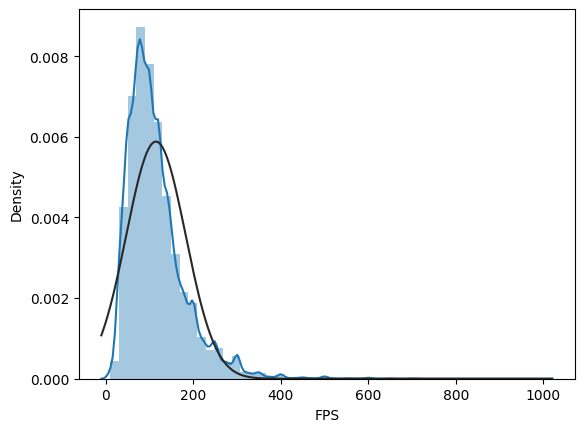

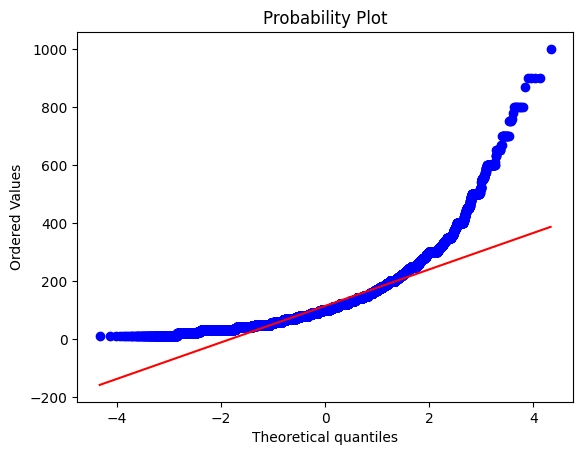

In [9]:
# Visualize the distribution of the objective variable (FPS)
sns.distplot(df['FPS'],fit=norm);
fig = plt.figure()
res = stats.probplot(df['FPS'], plot=plt)

In [10]:
# View columns that are categorical
df.select_dtypes(include='object').columns

Index(['GpuArchitecture', 'GpuBus nterface', 'GpuDirectX', 'GpuMemoryType',
       'GameName', 'GameSetting'],
      dtype='object')

In [11]:
# Separating the features in nominal and ordinal categories
nominal = ['GpuArchitecture', 'GameName']
ordinal = ['GpuBus nterface', 'GpuDirectX', 'GpuMemoryType', 'GameSetting']

In [12]:
# Mapping the ordinal columns
mappings = [
    {
        'col': 'GpuBus nterface',
        'mapping': {
            'PCIe 2.0 x8': 0,
            'PCIe 2.0 x16': 1,
            'PCIe 3.0 x4': 2,
            'PCIe 3.0 x8': 3,
            'PCIe 3.0 x16': 4,
            'MXM-A (3.0)': 5,
            'MXM-B (3.0)': 6,
            'PCIe 4.0 x16': 7,
        } 
    },
    {
        'col': 'GpuDirectX',
        'mapping': {
            '12': 0,
            '12 Ultimate': 1,
        }
    },
    {
        'col': 'GpuMemoryType',
        'mapping': {
            'GDDR3': 0,
            'DDR3': 1,
            'GDDR5': 2,
            'GDDR5X': 3,
            'GDDR6': 4,
            'HBM': 5,
            'HBM2': 6,
        }
    },
    {
        'col': 'GameSetting',
        'mapping': {
            'low': 0,
            'med': 1,
            'high': 2,
            'max': 3,
        }
    },
]

In [13]:
# One-hot encoding the nominal columns and ordinal encoding the ordinal columns
onehotenc = OneHotEncoder(cols = nominal)
ordinalenc = OrdinalEncoder(cols = ordinal, mapping = mappings)

In [14]:
# Splitting the dataset into features and target
X = df.drop('FPS', axis = 'columns')
Y = df['FPS']

In [15]:
# We create a pipeline to preprocess the data
nominal_transformer = Pipeline(
    steps=[
        ('nominal', onehotenc)
    ]
)
ordinal_transformer = Pipeline(
    steps=[
        ('ordinal', ordinalenc)
    ]
)

mapper = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal),
        ('ordinal', ordinal_transformer, ordinal)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('mapper', mapper),
        ('scaler', StandardScaler())
    ]
)

In [16]:
# Convert the data to a DataFrame after preprocessing
encoded = pipeline.fit_transform(X)
X_transformed = pd.DataFrame(encoded, columns=pipeline.named_steps['mapper'].get_feature_names_out())
print(X_transformed.shape)
X_transformed.head()

(93695, 85)


,nominal__GpuArchitecture_1,nominal__GpuArchitecture_2,nominal__GpuArchitecture_3,nominal__GpuArchitecture_4,nominal__GpuArchitecture_5,nominal__GpuArchitecture_6,nominal__GpuArchitecture_7,nominal__GpuArchitecture_8,nominal__GpuArchitecture_9,nominal__GpuArchitecture_10,nominal__GpuArchitecture_11,nominal__GpuArchitecture_12,nominal__GpuArchitecture_13,nominal__GpuArchitecture_14,nominal__GameName_1,nominal__GameName_2,nominal__GameName_3,nominal__GameName_4,nominal__GameName_5,nominal__GameName_6,nominal__GameName_7,nominal__GameName_8,nominal__GameName_9,nominal__GameName_10,nominal__GameName_11,nominal__GameName_12,nominal__GameName_13,nominal__GameName_14,nominal__GameName_15,nominal__GameName_16,nominal__GameName_17,nominal__GameName_18,nominal__GameName_19,nominal__GameName_20,nominal__GameName_21,nominal__GameName_22,nominal__GameName_23,nominal__GameName_24,nominal__GameName_25,nominal__GameName_26,nominal__GameName_27,nominal__GameName_28,nominal__GameName_29,nominal__GameName_30,ordinal__GpuBus nterface,ordinal__GpuDirectX,ordinal__GpuMemoryType,ordinal__GameSetting,remainder__CpuNumberOfCores,remainder__CpuNumberOfThreads,remainder__CpuBaseClock,remainder__CpuCacheL1,remainder__CpuCacheL2,remainder__CpuCacheL3,remainder__CpuFrequency,remainder__CpuMultiplier,remainder__CpuMultiplierUnlocked,remainder__CpuProcessSize,remainder__CpuTDP,remainder__CpuTurboClock,remainder__GpuBandwidth,remainder__GpuBaseClock,remainder__GpuBoostClock,remainder__GpuDieSize,remainder__GpuFP32Performance,remainder__GpuMemoryBus,remainder__GpuMemorySize,remainder__GpuOpenCL,remainder__GpuPixelRate,remainder__GpuProcessSize,remainder__GpuNumberOfROPs,remainder__GpuNumberOfShadingUnits,remainder__GpuNumberOfTMUs,remainder__GpuTextureRate,remainder__GpuNumberOfTransistors,remainder__GameResolution,remainder__GpuCpuRatio,remainder__CacheCoreRatio,remainder__CpuOverclockPotential,remainder__EffectiveMemory,remainder__PerformanceClockRatio,remainder__PerformancePerWatt,remainder__CpuCoreThreadRatio,remainder__CpuPowerIndex,remainder__GpuAverageClock
0,2.591273,-0.273504,-0.187711,-0.681282,-0.135163,-0.340023,-0.120226,-0.13185,-0.406628,-0.354135,-0.153214,-0.142511,-0.024888,-0.006534,3.227456,-0.177953,-0.299084,-0.230964,-0.334626,-0.319895,-0.300226,-0.232983,-0.202308,-0.265323,-0.131136,-0.159272,-0.204073,-0.198795,-0.144986,-0.152189,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-1.192351,-0.334133,-0.528652,-0.753155,-1.557178,-0.934173,-0.363226,-0.935178,-0.662433,-0.769683,-0.76658,-0.10481,-1.207621,-0.494537,-2.056202,-1.850897,-1.473948,-0.584372,-0.619360,-1.371452,-1.283650,-0.609834,-1.152785,1.782736,-1.247174,-0.731210,-1.404642,-1.393719,-1.452804,-1.335471,-1.104300,0.079105,0.354949,0.480816,-0.748145,-0.436408,-0.496535,-1.466322,-0.866799,-0.604954,-0.607137
1,2.591273,-0.273504,-0.187711,-0.681282,-0.135163,-0.340023,-0.120226,-0.13185,-0.406628,-0.354135,-0.153214,-0.142511,-0.024888,-0.006534,-0.309842,5.619451,-0.299084,-0.230964,-0.334626,-0.319895,-0.300226,-0.232983,-0.202308,-0.265323,-0.131136,-0.159272,-0.204073,-0.198795,-0.144986,-0.152189,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-1.192351,-0.334133,-0.528652,0.161551,-1.557178,-0.934173,-0.363226,-0.935178,-0.662433,-0.769683,-0.76658,-0.10481,-1.207621,-0.494537,-2.056202,-1.850897,-1.473948,-0.584372,-0.619360,-1.371452,-1.283650,-0.609834,-1.152785,1.782736,-1.247174,-0.731210,-1.404642,-1.393719,-1.452804,-1.335471,-1.104300,-1.804441,0.354949,0.480816,-0.748145,-0.436408,-0.496535,-1.466322,-0.866799,-0.604954,-0.607137
2,-0.385911,3.656254,-0.187711,-0.681282,-0.135163,-0.340023,-0.120226,-0.13185,-0.406628,-0.354135,-0.153214,-0.142511,-0.024888,-0.006534,-0.309842,-0.177953,3.343539,-0.230964,-0.334626,-0.319895,-0.300226,-0.232983,-0.202308,-0.265323,-0.13113

In [17]:
# Save the pipeline
joblib.dump(pipeline, '../models/pipeline.pkl')

['../models/pipeline.pkl']

In [18]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_transformed, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((74956, 85), (18739, 85), (74956,), (18739,))

## Modelization

Definimos como métrica de validación el RMSE ya que es una métrica útil para problemas de regresión.

Utilizaremos los modelos de Random Forest Regressor y LightGBM Regressor

### Random Forest Regressor

In [19]:
# Function to view metrics MAE, MSE, RMSE and MAPE
def metrics(y_test, y_pred):
    mae = np.mean(np.abs(y_test - y_pred))
    mse = np.mean(np.square(y_test - y_pred))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

In [20]:
# Basic model of Random Forest Regressor
rf_model_basic = RandomForestRegressor(random_state=123, n_jobs=-1)
rf_model_basic.fit(X_train, y_train)
y_pred = rf_model_basic.predict(X_test)
metrics(y_test, y_pred)

MAE: 22.90408173020569
MSE: 1694.040895736588
RMSE: 41.158728062667194
MAPE: 25.175422372300726


Obtenemnos un RMSE de 41.15 con un modelo básico de Random Forest. Ahora veremos las variables que han tomado más importancia en el entrenamiento del modelo.

In [21]:
# View importance of predictors
importancia_predictores = pd.DataFrame({'predictor': X_transformed.columns, 'importancia': rf_model_basic.feature_importances_})
importancia_predictores.sort_values('importancia', ascending=True).T

,13,12,4,10,11,50,6,7,38,1,32,39,0,2,8,45,35,5,3,44,42,9,67,29,25,65,69,34,46,19,21,31,17,36,40,26,30,82,70,66,27,48,33,28,16,52,41,56,72,63,79,49,71,62,84,37,51,61,53,43,77,74,60,57,81,59,22,54,55,58,24,73,20,14,80,76,83,64,75,78,23,47,15,68,18
predictor,nominal__GpuArchitecture_14,nominal__GpuArchitecture_13,nominal__GpuArchitecture_5,nominal__GpuArchitecture_11,nominal__GpuArchitecture_12,remainder__CpuBaseClock,nominal__GpuArchitecture_7,nominal__GpuArchitecture_8,nominal__GameName_25,nominal__GpuArchitecture_2,nominal__GameName_19,nominal__GameName_26,nominal__GpuArchitecture_1,nominal__GpuArchitecture_3,nominal__GpuArchitecture_9,ordinal__GpuDirectX,nominal__GameName_22,nominal__GpuArchitecture_6,nominal__GpuArchitecture_4,ordinal__GpuBus nterface,nominal__GameName_29,nominal__GpuArchitecture_10,remainder__GpuOpenCL,nominal__GameName_16,nominal__GameName_12,remainder__GpuMemoryBus,remainder__GpuProcessSize,nominal__GameName_21,ordinal__GpuMemoryType,nominal__GameName_6,nominal__GameName_8,nominal__GameName_18,nominal__GameName_4,nominal__GameName_23,nominal__GameName_27,nominal__GameName_13,nominal__GameName_17,remainder__CpuCoreThreadRatio,remainder__GpuNumberOfROPs,remainder__GpuMemorySize,nominal__GameName_14,remainder__CpuNumberOfCores,nominal__GameName_20,nominal__GameName_15,nominal__GameName_3,remainder__CpuCacheL2,nominal__GameName_28,remainder__CpuMultiplierUnlocked,remainder__GpuNumberOfTMUs,remainder__GpuDieSize,remainder__EffectiveMemory,remainder__CpuNumberOfThreads,remainder__GpuNumberOfShadingUnits,remainder__GpuBoostClock,remainder__GpuAverageClock,nominal__GameName_24,remainder__CpuCacheL1,remainder__GpuBaseClock,remainder__CpuCacheL3,nominal__GameName_30,remainder__CacheCoreRatio,remainder__GpuNumberOfTransistors,remainder__GpuBandwidth,remainder__CpuProcessSize,remainder__PerformancePerWatt,remainder__CpuTurboClock,nominal__GameName_9,remainder__CpuFrequency,remainder__CpuMultiplier,remainder__CpuTDP,nominal__GameName_11,remainder__GpuTextureRate,nominal__GameName_7,nominal__GameName_1,remainder__PerformanceClockRatio,remainder__GpuCpuRatio,remainder__CpuPowerIndex,remainder__GpuFP32Performance,remainder__GameResolution,remainder__CpuOverclockPotential,nominal__GameName_10,ordinal__GameSetting,nominal__GameName_2,remainder__GpuPixelRate,nominal__GameName_5
importancia,0.000003,0.000035,0.00007,0.000107,0.000123,0.000132,0.000257,0.000306,0.000342,0.000395,0.000395,0.000396,0.000459,0.000522,0.000538,0.000679,0.000684,0.000779,0.00086,0.0009,0.000951,0.000965,0.001175,0.00142,0.00147,0.001502,0.001505,0.001723,0.001814,0.00182,0.001864,0.002167,0.002217,0.002317,0.002411,0.00264,0.002763,0.002861,0.002874,0.002912,0.002912,0.003336,0.00334,0.00352,0.003571,0.00398,0.004519,0.004627,0.004634,0.004824,0.005342,0.005584,0.005612,0.005774,0.00582,0.005846,0.006428,0.006895,0.007732,0.0085,0.008683,0.008707,0.009507,0.012391,0.012419,0.012468,0.012948,0.013464,0.01549,0.015727,0.01607,0.01634,0.018612,0.018967,0.02405,0.024202,0.028478,0.032717,0.034281,0.062154,0.065689,0.069229,0.073141,0.119218,0.124902


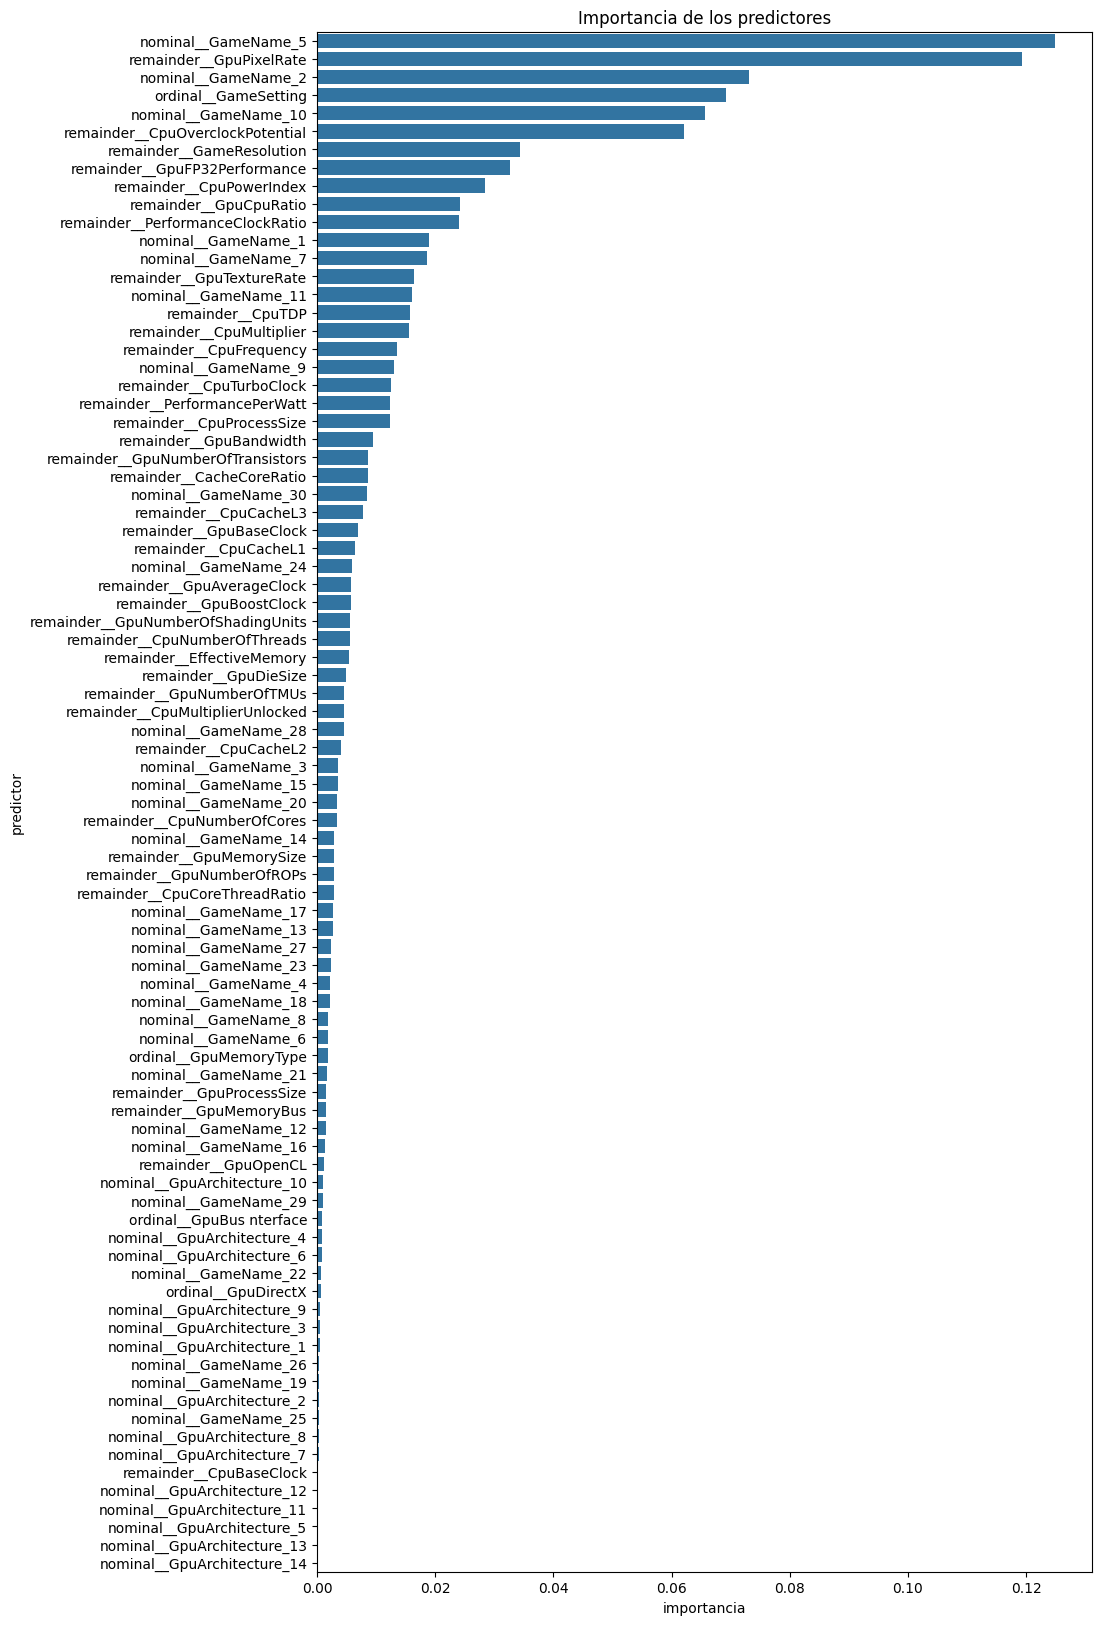

In [22]:
# Graph importance of variables sorting descending
plt.figure(figsize=(10, 20))
sns.barplot(x='importancia', y='predictor', data=importancia_predictores.sort_values('importancia', ascending=False))
plt.title('Importancia de los predictores')
plt.show()

Hemos identificado que hay tres variables que no aportan ninguna importancia al modelo, así como otras con una importancia muy baja, lo que limita la capacidad de generalización del modelo. Por lo tanto, realizaremos un nuevo entrenamiento del Random Forest Regressor, eliminando estas variables, para evaluar la diferencia en términos de precisión.

In [23]:
# Train again without predictors with less than 1% importance
drop_columns = importancia_predictores[importancia_predictores['importancia'] < 0.01]
X_transformed2 = X_transformed.drop(columns = drop_columns['predictor'], axis=1)
# Splitting the new data into training and testing
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_transformed2, Y, test_size=0.2, random_state=123)

# Train again the basic model of Random Forest Regressor
rf_model_basic2 = RandomForestRegressor(n_estimators=100, random_state=123, n_jobs=-1)
rf_model_basic2.fit(X_train2, y_train2)
y_pred2 = rf_model_basic2.predict(X_test2)
metrics(y_test2, y_pred2)

MAE: 28.99954778063658
MSE: 1999.4096061903726
RMSE: 44.71475825933059
MAPE: 31.82800583977481


Después de eliminar las variables con menos del 1% de importancia, observamos que el RMSE del modelo de Random Forest ha aumentado de 41.1 a 44.7. Sin embargo, el tiempo de ejecución del modelo ha disminuido y como la diferencia es de 3 puntos, nos lleva a concluir que el modelo ahora generaliza mejor y se ejecuta más rápido.

### Tunning Random Forest Classifier with Optuna

Ahora al modelo de Random Forest Classifier se le realizará un tuneo de hiperparámetros con la técnica genética avanzada Optuna

In [24]:
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def objective_rf(trial):
    # Definimos los hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 32),
    }

    rf_optuna = RandomForestRegressor(random_state=123, **params)
    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    return rmse

# Creamos el estudio para optimizar los hiperparámetros
sampler = TPESampler(seed=42)
study_rf = optuna.create_study(direction="minimize", sampler=sampler)
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True, n_jobs=12)

print('Mejores hiperparámetros:', study_rf.best_params)
print('Mejor score de precisión ponderada:', study_rf.best_value)

[I 2024-11-19 05:40:42,887] A new study created in memory with name: no-name-97ff0a63-e753-4321-b28e-14f68c0b08de


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-19 05:41:33,805] Trial 2 finished with value: 41.66612095400911 and parameters: {'n_estimators': 23, 'max_depth': 25}. Best is trial 2 with value: 41.66612095400911.
[I 2024-11-19 05:43:07,274] Trial 12 finished with value: 41.61164953048041 and parameters: {'n_estimators': 75, 'max_depth': 17}. Best is trial 12 with value: 41.61164953048041.
[I 2024-11-19 05:43:27,237] Trial 5 finished with value: 41.64675591240797 and parameters: {'n_estimators': 130, 'max_depth': 16}. Best is trial 12 with value: 41.61164953048041.
[I 2024-11-19 05:43:53,884] Trial 8 finished with value: 41.640517451633656 and parameters: {'n_estimators': 152, 'max_depth': 16}. Best is trial 12 with value: 41.61164953048041.
[I 2024-11-19 05:44:31,461] Trial 7 finished with value: 41.91630171671989 and parameters: {'n_estimators': 228, 'max_depth': 13}. Best is trial 12 with value: 41.61164953048041.
[I 2024-11-19 05:45:17,261] Trial 4 finished with value: 41.0597032754373 and parameters: {'n_estimators':

Nos damos cuenta que existen CpuName, GpuName y Game iguales pero con FPS distintos. Así que sacamos el promedio de FPS para ponerlo en una sola fila, ya que las demás variables dependen de estas 3 características.

In [25]:
optuna.visualization.plot_param_importances(study_rf)

In [ ]:
# Train RandomForestRegressor with the best hyperparameters of Optuna
rf_best_model = RandomForestRegressor(**study_rf.best_params, n_jobs=-1)
rf_best_model.fit(X_train, y_train)
y_pred = rf_best_model.predict(X_test)
metrics(y_test, y_pred)

MAE: 23.16646471296623
MSE: 1686.1698623103177
RMSE: 41.06299870090247
MAPE: 25.533399538549578


Tras ejecutar Optuna para el tuneo de hiperparámetros de Random Forest Regressor, observamos una mejora en el RMSE, que pasó de 41.15 a 41.06. Esto sugiere que, con una búsqueda más exhaustiva, la precisión podría incrementarse aún más y sería intersante probar otros modelos para este problema de regresión.

### LightGBM Regressor

In [20]:
# Basic model of LGBMRegressor
lgbm_model_basic = LGBMRegressor(n_estimators = 100, random_state = 123, n_jobs=-1)
lgbm_model_basic.fit(X = X_train, y = y_train)
y_pred = lgbm_model_basic.predict(X = X_test)

# Cross-validation with RMSE
metrics(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 74956, number of used features: 84
[LightGBM] [Info] Start training from score 114.250774
MAE: 22.7921989772649
MSE: 1531.3302301050649
RMSE: 39.13221473549721
MAPE: 25.18086293679343


Después de utilizar un modelo básico de LGBM obtenemos un RMSE de 39.13

### LGBM Regressor with Optuna

Ahora realizaremos el tuneo de hiperparámetros para LGBM Regressor utilizando la técnica genética avanzada optuna.

In [ ]:
def objective(trial):
    # Define the hiperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 300, step=10)
    max_depth = trial.suggest_int("max_depth", 3, 8)
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 100, step=10)
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "min_child_samples": min_child_samples,
        "random_state": 100
    }
    lgbm_model_optuna = LGBMRegressor(**params)
    
    # Validate the model with RMSE as the metric
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model_optuna, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')))
    return rmse

# Create the study to optimize the hyperparameters
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=12)

# Visualize the best hyperparameters and the best score
print('Mejores hiperparámetros:', study_lgbm.best_params) 
print('Mejor score de RMSE ponderada:', study_lgbm.best_value)

[I 2024-11-19 07:20:50,204] A new study created in memory with name: no-name-6c791e25-d147-4732-8c3f-f2accce855dd


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-19 07:20:54,593] Trial 2 finished with value: 48.109819572497166 and parameters: {'n_estimators': 30, 'max_depth': 3, 'subsample': 0.866749211801175, 'colsample_bytree': 0.8287314742595058, 'min_child_samples': 10}. Best is trial 2 with value: 48.109819572497166.
[I 2024-11-19 07:20:58,347] Trial 1 finished with value: 41.726575436215704 and parameters: {'n_estimators': 40, 'max_depth': 6, 'subsample': 0.5976512232156671, 'colsample_bytree': 0.7201792904803335, 'min_child_samples': 30}. Best is trial 1 with value: 41.726575436215704.
[I 2024-11-19 07:20:59,347] Trial 4 finished with value: 41.249241174207704 and parameters: {'n_estimators': 40, 'max_depth': 7, 'subsample': 0.8590857069315034, 'colsample_bytree': 0.6250669074064232, 'min_child_samples': 30}. Best is trial 4 with value: 41.249241174207704.
[I 2024-11-19 07:21:02,775] Trial 5 finished with value: 39.785894519991984 and parameters: {'n_estimators': 90, 'max_depth': 6, 'subsample': 0.6986760071028084, 'colsample_

In [31]:
# Train with the best hyperparameters of LGBM Regressor
params = study_lgbm.best_params
lgbm_model_best_params = LGBMRegressor(**params)
lgbm_model_best_params.fit(X_train, y_train)
y_pred = lgbm_model_best_params.predict(X_test)
metrics(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 74956, number of used features: 83
[LightGBM] [Info] Start training from score 114.250774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MAE: 22.085154210603744
MSE: 1498.4966017607062
RMSE: 38.71041980863429
MAPE: 24.330918982931678


In [32]:
# Save the models with the best hyperparameters
with open('../models/regressor/rf_model_regressor.pkl', 'wb') as li:
    pickle.dump(rf_best_model, li)
with open('../models/regressor/lgbm_model_regressor.pkl', 'wb') as lo:
    pickle.dump(lgbm_model_best_params, lo)